In [14]:
from datetime import datetime

import librosa.display
from dotenv import load_dotenv
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

In [15]:
# 指定 STFT 參數
load_dotenv()
sample_rate = int(os.getenv('sample_rate'))
n_mels = int(os.getenv('n_mels'))
# n_fft = int(os.getenv('n_fft'))

print(f'Sample rate: {sample_rate}, n_mels: {n_mels}')

Sample rate: 48000, n_mels: 128


# 1. 資料加載與標記

In [16]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

def load_segmented_files(directory):
    wav_files = []
    leak_wav_files = []
    for dir in os.listdir(directory):
        if not os.path.isdir(os.path.join(directory, dir)):
            continue
        for file in os.listdir(os.path.join(directory, dir)):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(directory, dir, file)
            y, sr = librosa.load(file_path, sr=None)
            filename = f'{dir}_{file}'
            if 'no-leak' in dir:
                wav_files.append((y, sr, filename))
            else:
                leak_wav_files.append((y, sr, filename))
    return wav_files, leak_wav_files

def create_dataset(directory, max_length=None):
    wav_files, leak_wav_files = load_segmented_files(directory)
    
    # 將資料轉為 NumPy 格式
    X = []
    y = []
    
    for audio, sr, filename in wav_files:
        X.append((audio, sr))
        y.append(0)  # wav_files 標記為 0
    
    for audio, sr, filename in leak_wav_files:
        X.append((audio, sr))
        y.append(1)  # leak_wav_files 標記為 1
    
    return X, np.array(y)


# 2. 特徵提取與資料預處理

In [24]:
from data_preprocess import extract_features

def preprocess_data(X, desired_time=2.0, n_mels=128, n_fft=2048, hop_length=512):
    features = []
    for audio, sr in X:
        feature = extract_features(audio, sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, desired_time=desired_time)
        features.append(feature)
    return np.array(features)


# 3. 建立 CNN 模型

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape=(128, 128, 1)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))  # 二元分類使用 sigmoid 激活函數
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [26]:
def create_training_data(desired_time=2.0, directory='training_data'):
    X, y = create_dataset(directory)
    
    print(f"總樣本數: {len(X)}")
    print(f"標籤分佈: {np.bincount(y)}")
    
    
    X_features = preprocess_data(X, desired_time=desired_time)
    
    print(f"特徵形狀: {X_features.shape}")  # 預期形狀: (樣本數, max_len, n_mels)
    
    # 正規化特徵
    X_features = (X_features - np.mean(X_features)) / np.std(X_features)
    
    # 擴展維度以符合 CNN 輸入 (樣本數, 高, 寬, 通道)
    X_features = np.expand_dims(X_features, -1)  # 新形狀: (樣本數, max_len, n_mels, 1)
    
    # 分割訓練集與測試集
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
    
    print(f"訓練集形狀: {X_train.shape}")
    print(f"測試集形狀: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [27]:
def create_model(mockup_input):
    # 計算實際的 max_len
    desired_time = 2.0  # 設定為 2 秒
    sr_example = X[0][1]  # 取一個樣本的取樣率
    max_len = int(np.ceil((desired_time * sr_example) / 512))
    print(f"設定的 max_len（時間幀數）: {max_len}")
    
    # 建立模型
    input_shape = (mockup_input.shape[1], mockup_input.shape[2], 1)
    model = create_cnn_model(input_shape)
    model.summary()
    return model

# 4. 訓練模型

In [21]:
def train_model(model, X_train, X_test, y_train, y_test, epochs=30, batch_size=32):
        # 訓練模型
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test)
    )
    
    # 評估模型
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.2f}")
    
    return model, history

In [22]:
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.2f}")

In [28]:
X_train, X_test, y_train, y_test = create_training_data(directory='training_data')

總樣本數: 12717
標籤分佈: [10641  2076]
特徵形狀: (12717, 188, 128)
訓練集形狀: (10173, 188, 128, 1)
測試集形狀: (2544, 188, 128, 1)


In [29]:
cnn_model = create_model(X_train)

設定的 max_len（時間幀數）: 188
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 186, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 93, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 93, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 91, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (Non

In [30]:
model, history = train_model(cnn_model, X_train, X_test, y_train, y_test, epochs=30)

Epoch 1/30
318/318 [==============================] - 15s 25ms/step - loss: 0.4552 - accuracy: 0.8305 - val_loss: 0.3536 - val_accuracy: 0.8785
Epoch 2/30
318/318 [==============================] - 7s 23ms/step - loss: 0.3262 - accuracy: 0.8560 - val_loss: 0.2788 - val_accuracy: 0.8856
Epoch 3/30
318/318 [==============================] - 7s 23ms/step - loss: 0.3126 - accuracy: 0.8592 - val_loss: 0.2728 - val_accuracy: 0.9006
Epoch 4/30
318/318 [==============================] - 7s 23ms/step - loss: 0.2977 - accuracy: 0.8703 - val_loss: 0.2660 - val_accuracy: 0.8931
Epoch 5/30
318/318 [==============================] - 7s 23ms/step - loss: 0.2909 - accuracy: 0.8835 - val_loss: 0.2983 - val_accuracy: 0.8695
Epoch 6/30
318/318 [==============================] - 7s 23ms/step - loss: 0.2838 - accuracy: 0.8841 - val_loss: 0.2563 - val_accuracy: 0.8935
Epoch 7/30
318/318 [==============================] - 7s 23ms/step - loss: 0.2791 - accuracy: 0.8877 - val_loss: 0.2518 - val_accuracy: 0.900

In [31]:
evaluate_model(cnn_model, X_test, y_test)

80/80 [==============================] - 1s 8ms/step - loss: 0.2531 - accuracy: 0.9127
Test loss: 0.2531
Test accuracy: 0.91


In [32]:
date = datetime.now().strftime('%Y%m%d%H%M')
model.save(f'model_{date}.h5')
print(f"Model saved as model_{date}.h5")

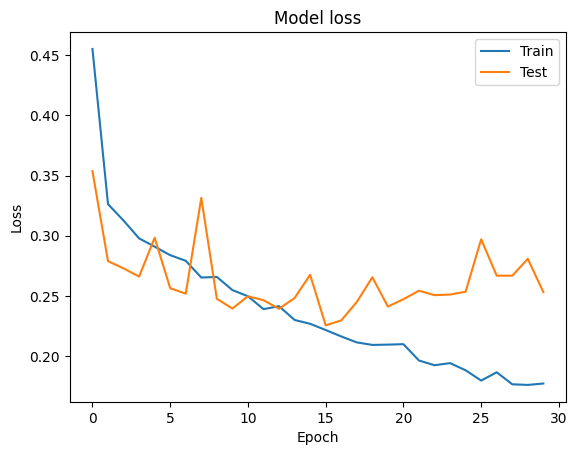

In [34]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(f'model_loss_{date}.png')
plt.show()